In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Landscape of the crosslinking negative log likelihood version 2.0 from Riccardo Pellarin

* The likelihood is given by $$P(O_n|X) = \frac{\alpha}{\beta}P(XL_n|X) + \frac{(1-\alpha)}{1-\beta}P(\bar{XL_n}|X)$$
* $\alpha = \frac{N^{obs, T}_{XL}}{N^{obs}_{XL}}$ and $\beta = \frac{N_{XL}}{N_{LP}}$, also $\alpha$ and $\beta$ satisfy constrains $$\frac{\alpha}{\beta}\leq\frac{N_{LP}}{N^{obs}_{XL}};\quad \frac{1-\alpha}{1-\beta}\leq\frac{N_{LP}}{N^{obs}_{XL}}$$

* Example system
1) Consider 100 lysines, 4950 lysine pairs and 100 crosslinks observed
2) Assumptions
    - All the 100 crosslinks have the same forward model probability 
    - All the crosslinks also have the same $\alpha$ and $\beta$ parameters

## For trifunctional crosslinking MS

* The number of lysine triplets for a given $N_{lysine}$ scales as $\frac{N_{lysine}(N_{lysine}-1)(N_{lysine}-2)}{6}$


Processing fm=0.00...
  Global minimum: -3.901973
  Found 1 minima within rtol=1e-11

Processing fm=0.25...
  Global minimum: -3.617703
  Found 1 minima within rtol=1e-11

Processing fm=0.50...
  Global minimum: -3.219028
  Found 2 minima within rtol=1e-11

Processing fm=0.75...
  Global minimum: -3.617703
  Found 1 minima within rtol=1e-11

Processing fm=1.00...
  Global minimum: -3.901973
  Found 1 minima within rtol=1e-11


/tmp/ipykernel_254719/3971473557.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


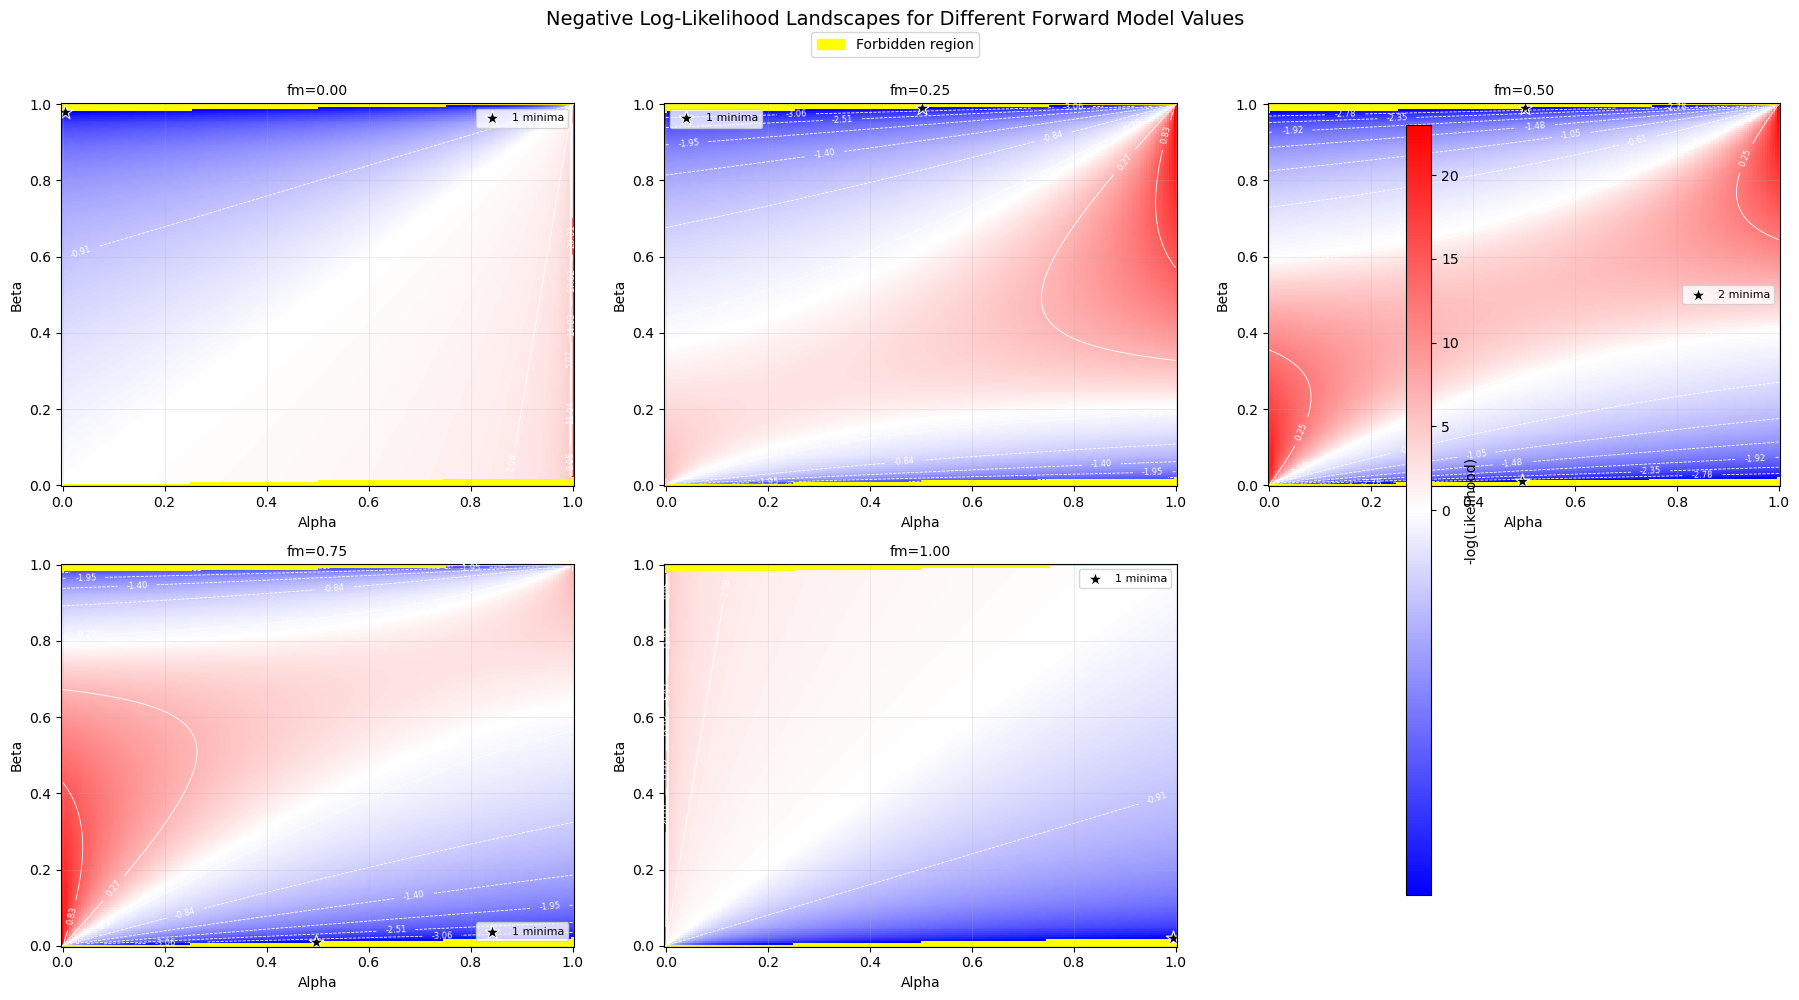

In [5]:
# More 2D plots to analyze the effect of alpha and beta on the scoring function
# First define some of the system parameters
n_lysines = 100
n_lysine_pairs = n_lysines * (n_lysines - 1) // 2
n_lysine_triplets = n_lysines * (n_lysines - 1) * (n_lysines - 2) // 6
n_xls_observed = 100

def likelihood(fm, alpha, beta):
    prob_true = fm
    prob_false = 1 - fm
    likelihood_value = (alpha / beta) * prob_true + ((1 - alpha) / (1 - beta)) * prob_false
    nll = -np.log(likelihood_value + 1e-300)  # negative log-likelihood
    return nll

def compute_landscape(fmod, n_lysine_pairs, n_xls_observed):
    '''
    Compute the -log(likelihood) landscape for a given fmod value.
    Returns the surface, grid values, and minima information.
    '''
    alpha_vals = np.linspace(1e-10, 1.0 - 1e-10, 200)
    beta_vals  = np.linspace(1.0 - 1e-10, 1e-10, 200)

    # constraints: alpha/beta <= (n_lysine_pairs / n_xls_observed) and (1-alpha)/(1-beta) <= same bound
    K = (n_lysine_pairs / n_xls_observed)
    eps = 1e-12  # numerical guard to avoid division by zero

    # Build surface; NaN marks forbidden regions (to color them distinctly)
    lhood_surface = np.full((len(beta_vals), len(alpha_vals)), np.nan)
    for j, b in enumerate(beta_vals):
        for i, a in enumerate(alpha_vals):
            cond1 = (a / (b + eps)) <= K
            cond2 = ((1 - a) / ((1 - b) + eps)) <= K
            if cond1 and cond2:
                lhood_surface[j, i] = likelihood(fmod, a, b)

    # Find minima over valid region
    valid_mask = np.isfinite(lhood_surface)
    minima_info = {'has_minima': False}
    
    if np.any(valid_mask):
        global_min = np.nanmin(lhood_surface[valid_mask])

        # Minima tolerance: mark all cells within rtol/atol of the global min
        minima_rtol = 1e-11   # 0.1% relative to value
        minima_atol = 1e-11
        minima_mask = valid_mask & np.isclose(lhood_surface, global_min, rtol=minima_rtol, atol=minima_atol)
        minima_idx = np.argwhere(minima_mask)

        if minima_idx.size > 0:
            min_alphas = alpha_vals[minima_idx[:, 1]]
            min_betas  = beta_vals[minima_idx[:, 0]]
            
            minima_info = {
                'has_minima': True,
                'min_value': global_min,
                'min_alphas': min_alphas,
                'min_betas': min_betas,
                'count': len(minima_idx),
                'rtol': minima_rtol
            }

    return lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info

def plot_single_landscape(ax, fmod, lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info):
    '''
    Plot a single landscape on the given axis.
    '''
    import matplotlib.patches as mpatches
    from matplotlib.colors import TwoSlopeNorm
    
    # Blue (low) -> White (mid) -> Red (high); NaNs (forbidden) shown in yellow
    Z = np.ma.masked_invalid(lhood_surface)
    cmap = plt.cm.bwr.copy()
    cmap.set_bad('yellow')  # forbidden regions in yellow

    # Center white at the median of valid values
    vmin = float(Z.min()) if Z.size and np.any(valid_mask) else 0.0
    vmax = float(Z.max()) if Z.size and np.any(valid_mask) else 1.0
    vcenter = float(np.ma.median(Z)) if Z.size and np.any(valid_mask) else 0.5
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    mesh = ax.pcolormesh(alpha_vals, beta_vals, Z, cmap=cmap, norm=norm, shading='auto')

    # Add contours over valid regions
    if Z.size and np.any(valid_mask):
        levels = np.linspace(vmin, vmax, 10)
        cs = ax.contour(alpha_vals, beta_vals, Z.filled(np.nan), levels=levels, 
                       colors='white', linewidths=0.6)
        ax.clabel(cs, inline=True, fontsize=6, fmt='%.2f')

    # Mark all minima
    if minima_info['has_minima']:
        ax.scatter(minima_info['min_alphas'], minima_info['min_betas'], 
                  marker='*', color='black', s=120,
                  edgecolors='white', linewidth=0.8,
                  label=f"{minima_info['count']} minima")

    ax.set_ylabel('Beta')
    ax.set_xlabel('Alpha')
    ax.set_title(f'fm={fmod:.2f}', fontsize=10)
    ax.grid(True, alpha=0.2)
    
    if minima_info['has_minima']:
        ax.legend(loc='best', fontsize=8)
    
    return mesh

def fmod_graphs(fmod_values, n_lysine_pairs, n_xls_observed):
    '''
    Create multiple side-by-side plots for different fmod values.
    
    Parameters:
    -----------
    fmod_values : list or array
        List of forward model probability values to plot
    n_lysine_pairs : int
        Number of lysine pairs in the system
    n_xls_observed : int
        Number of observed crosslinks
    '''
    import matplotlib.patches as mpatches
    
    n_plots = len(fmod_values)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = int(np.ceil(n_plots / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Ensure axes is always 2D array for consistent indexing
    if n_plots == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten for easy iteration
    axes_flat = axes.flatten()
    
    # Compute and plot each landscape
    all_meshes = []
    for idx, fmod in enumerate(fmod_values):
        print(f"\nProcessing fm={fmod:.2f}...")
        
        # Compute landscape
        lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info = \
            compute_landscape(fmod, n_lysine_pairs, n_xls_observed)
        
        # Print info
        if minima_info['has_minima']:
            print(f"  Global minimum: {minima_info['min_value']:.6f}")
            print(f"  Found {minima_info['count']} minima within rtol={minima_info['rtol']}")
        else:
            print(f"  No valid regions found")
        
        # Plot on appropriate axis
        ax = axes_flat[idx]
        mesh = plot_single_landscape(ax, fmod, lhood_surface, alpha_vals, beta_vals, 
                                     valid_mask, minima_info)
        all_meshes.append(mesh)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Add a single colorbar for all subplots
    fig.colorbar(all_meshes[0], ax=axes.ravel().tolist(), 
                label='-log(Likelihood)', pad=0.02, aspect=30)
    
    # Add global legend for forbidden regions
    forbidden_patch = mpatches.Patch(color='yellow', label='Forbidden region')
    fig.legend(handles=[forbidden_patch], loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=1, fontsize=10)
    
    fig.suptitle('Negative Log-Likelihood Landscapes for Different Forward Model Values', 
                fontsize=14, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Example usage: Plot for multiple fmod values
fmod_values = [0.0, 0.25, 0.5, 0.75, 1.0]
fmod_graphs(fmod_values, n_lysine_pairs, n_xls_observed)

# Or for a more detailed exploration
# fmod_values = np.linspace(0.1, 0.9, 9)  # 9 values from 0.1 to 0.9
# fmod_graphs(fmod_values, n_lysine_pairs, n_xls_observed)

# Trifunctional crosslinking modeling

* In an experiment, there are trifunctional crosslinks and if one of the ends is a dead end then there are bifunctional crosslinks formed. Since these two cases occur in the same experiment for the same system, we need to model them in equal footing
* Consider that $N_{XL}$ number of crosslinks were formed in the experiment, then 
$$N_{XL} = N^{tri}_{XL} + N^{bi}_{XL}$$

Consider that there are $N_{L}$ number of lysines in the system, we define the $beta$ parameter as 
$$\beta = \frac{N_{XL}}{N_{LP}+N_{LT}} = \frac{N^{tri}_{XL}+ N^{bi}_{XL}}{N_{LP}+N_{LT}}$$

* This parameter incorporates noise due to the structure being what it is and chemical reactivity because not all of the lysines that could be crosslinked purely based on their proximity to each other actually can react with the crosslinker 

* We can plugin $N_{LP} = \frac{N_{L}(N_{L}-1)}{2}$ and $N_{LT} = \frac{N_{L}(N_{L}-1)(N_{L}-2)}{6}$
* plugging this into the formula for $\beta$ we get
$$\beta = \frac{N^{tri}_{XL}+ N^{bi}_{XL}}{\frac{N_{L}(N_{L}-1)}{2}+\frac{N_{L}(N_{L}-1)(N_{L}-2)}{6}}$$
Simplifying this leads to 
$$\beta = \frac{6\left(N^{tri}_{XL}+N^{bi}_{XL}\right)}{N_{L}(N_{L}-1)(N_{L}+1)}$$

* The $\alpha$ parameter is defined as
$$\alpha = \frac{N^{obs,T}_{XL}}{N^{obs}_{XL}} = \frac{N^{obs,tri,T}_{XL}+N^{obs,bi,T}_{XL}}{N^{obs,tri}_{XL}+N^{obs,bi}_{XL}}
$$ 

* To obtain bounds for the values of $\alpha$ and $\beta$

$$\frac{\alpha}{\beta} \leq \frac{N_L(N_L-1)(N_L+1)}{\left(N^{obs,tri}_{XL}+N^{obs,bi}_{XL}\right)}$$
and the same bound is obtained for
$$\frac{1-\alpha}{1-\beta} \leq \frac{N_L(N_L-1)(N_L+1)}{\left(N^{obs,tri}_{XL}+N^{obs,bi}_{XL}\right)}$$

1) Consider a system with $N_L=100$, $N^{obs}_{XL} = 100$, where $N^{obs,tri}_{XL} = 20$ and $N^{obs,bi}_{XL} = 80$ 
    - All crosslinks have the same forward model probability
    - All crosslinks have the same $\alpha$ and $\beta$ parameters

The total likelihood function can then be written as 

$$P(O_n|X) = \frac{\alpha}{\beta}P(XL_n|X) + \frac{1-\alpha}{1-\beta}P(\bar{XL_n|X}) $$

Here we can make some additional simplifications, an observed crosslink has two possibilities, a bifunctional or a trifunctional, so the first term in the forward model can be factorized as 
$$P(XL_n|X) = P(XL^{tri}_n|XL_n)P(XL^{tri}_n|X) + P(XL^{bi}_n|XL_n)P(XL^{bi}_n|X)$$


Processing fm_bi=0.00, fm_tri=0.20...
  Global minimum: -6.877121
  Found 1 minima within rtol=1e-08

Processing fm_bi=0.25, fm_tri=0.35...
  Global minimum: -6.603554
  Found 1 minima within rtol=1e-08

Processing fm_bi=0.50, fm_tri=0.45...
  Global minimum: -6.705343
  Found 1 minima within rtol=1e-08

Processing fm_bi=0.75, fm_tri=0.90...
  Global minimum: -7.170019
  Found 1 minima within rtol=1e-08

Processing fm_bi=1.00, fm_tri=1.00...
  Global minimum: -7.418480
  Found 1 minima within rtol=1e-08


/tmp/ipykernel_254719/1172462309.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


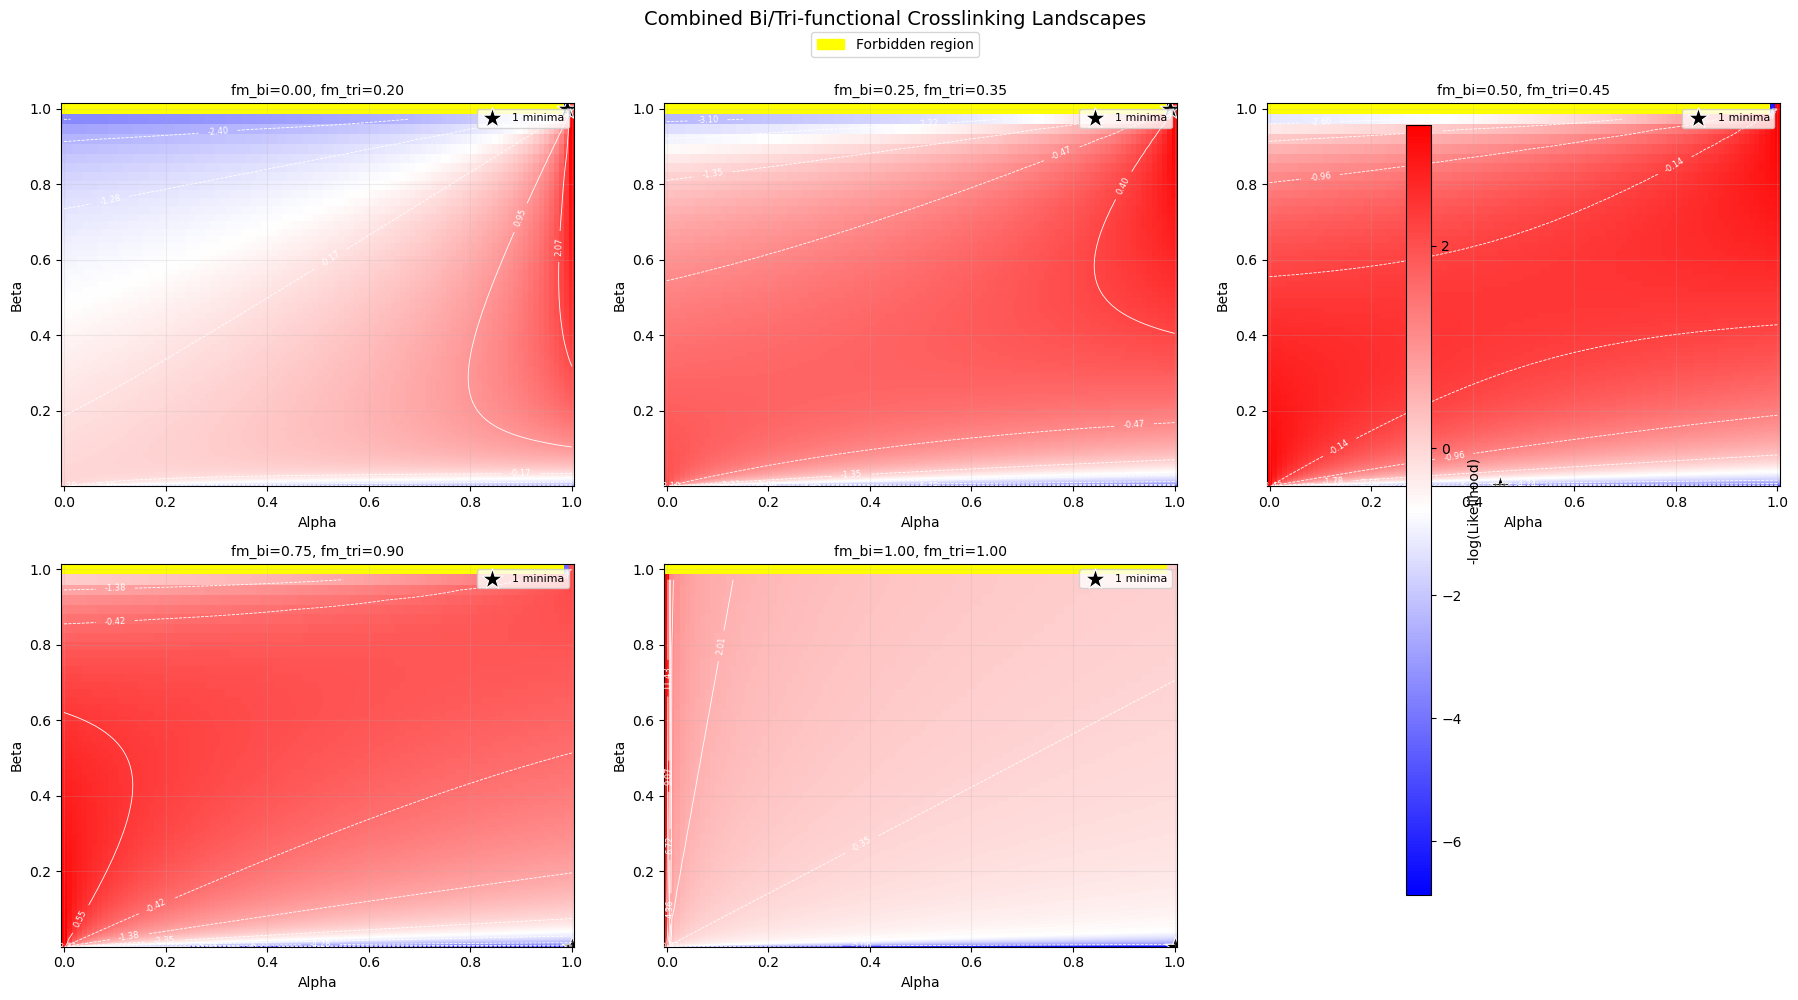

In [38]:

# System parameters
n_lysines = 100
n_xls_observed = 100
n_xls_observed_bi = 80
n_xls_observed_tri = n_xls_observed - n_xls_observed_bi
prob_xls_bi = n_xls_observed_bi / n_xls_observed
prob_xls_tri = n_xls_observed_tri / n_xls_observed

# A function to compute the negative log likelihood function given the forward models 
# for bi- and tri-functional crosslinking as well as the alpha and beta parameters

def negative_log_likelihood(fm_bi, fm_tri, alpha, beta):
    # Compute the likelihood for bi-functional crosslinks
    prob_true_bi = prob_xls_bi*fm_bi
    prob_true_tri = prob_xls_tri*fm_tri
    prob_true = prob_true_bi + prob_true_tri
    
    prob_false_bi = prob_xls_bi*(1 - fm_bi)
    prob_false_tri = prob_xls_tri*(1 - fm_tri)
    prob_false = prob_false_bi + prob_false_tri
    
    likelihood = (alpha / beta) * prob_true + ((1 - alpha) / (1 - beta)) * prob_false 
    nll = -np.log(likelihood + 1e-300)  # negative log-likelihood
    
    return nll

def compute_combined_likelihood_landscape(fm_bi, fm_tri, n_lysines, n_xls_observed):
    '''
    Compute the -log(likelihood) landscape for given fm_bi and fm_tri values.
    Returns the surface, grid values, and minima information.
    '''
    alpha_vals = np.linspace(1e-6, 1.0 - 1e-6, 100)

    beta_target = 6 * n_xls_observed / (n_lysines * (n_lysines - 1) * (n_lysines + 1))
    beta_min = max(1e-8, beta_target / 50.0)
    beta_max = 0.99999
    beta_vals = np.geomspace(beta_min, beta_max, 400)
    beta_vals = np.unique(np.concatenate([beta_vals, [beta_target, beta_max]]))
    beta_vals.sort()
    beta_vals = beta_vals[::-1]

    K = (n_lysines * (n_lysines - 1) * (n_lysines + 1)) / (6 * n_xls_observed)
    eps = 1e-12

    lhood_surface = np.full((len(beta_vals), len(alpha_vals)), np.nan)
    for j, b in enumerate(beta_vals):
        for i, a in enumerate(alpha_vals):
            cond1 = (a / (b + eps)) <= K
            cond2 = ((1 - a) / ((1 - b) + eps)) <= K
            if cond1 and cond2:
                lhood_surface[j, i] = negative_log_likelihood(fm_bi, fm_tri, a, b)

    valid_mask = np.isfinite(lhood_surface)
    minima_info = {'has_minima': False}

    if np.any(valid_mask):
        global_min = np.nanmin(lhood_surface[valid_mask])
        minima_rtol = 1e-8
        minima_atol = 1e-8
        minima_mask = valid_mask & np.isclose(lhood_surface, global_min, rtol=minima_rtol, atol=minima_atol)
        minima_idx = np.argwhere(minima_mask)

        if minima_idx.size > 0:
            min_alphas = alpha_vals[minima_idx[:, 1]]
            min_betas = beta_vals[minima_idx[:, 0]]
            minima_info = {
                'has_minima': True,
                'min_value': global_min,
                'min_alphas': min_alphas,
                'min_betas': min_betas,
                'count': len(minima_idx),
                'rtol': minima_rtol
            }

    return lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info

def plot_single_combined_landscape(ax, fm_bi, fm_tri, lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info):
    '''
    Plot a single combined landscape on the given axis.
    '''
    import matplotlib.patches as mpatches
    from matplotlib.colors import TwoSlopeNorm
    
    # Blue (low) -> White (mid) -> Red (high); NaNs (forbidden) shown in yellow
    Z = np.ma.masked_invalid(lhood_surface)
    cmap = plt.cm.bwr.copy()
    cmap.set_bad('yellow')  # forbidden regions in yellow

    # Center white at the median of valid values
    vmin = float(Z.min()) if Z.size and np.any(valid_mask) else 0.0
    vmax = float(Z.max()) if Z.size and np.any(valid_mask) else 1.0
    vcenter = float(np.ma.median(Z)) if Z.size and np.any(valid_mask) else 0.5
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    mesh = ax.pcolormesh(alpha_vals, beta_vals, Z, cmap=cmap, norm=norm, shading='auto')

    # Add contours over valid regions
    if Z.size and np.any(valid_mask):
        levels = np.linspace(vmin, vmax, 10)
        cs = ax.contour(alpha_vals, beta_vals, Z.filled(np.nan), levels=levels, 
                       colors='white', linewidths=0.6)
        ax.clabel(cs, inline=True, fontsize=6, fmt='%.2f')

    # Mark all minima
    if minima_info['has_minima']:
        ax.scatter(minima_info['min_alphas'], minima_info['min_betas'], 
                  marker='*', color='black', s=240,
                  edgecolors='white', linewidth=0.8,
                  label=f"{minima_info['count']} minima")

    ax.set_ylabel('Beta')
    ax.set_xlabel('Alpha')
    ax.set_title(f'fm_bi={fm_bi:.2f}, fm_tri={fm_tri:.2f}', fontsize=10)
    ax.grid(True, alpha=0.2)
    
    if minima_info['has_minima']:
        ax.legend(loc='best', fontsize=8)
    
    return mesh

def fmod_combined_graphs(fmod_bi_values, fmod_tri_values, n_lysines, n_xls_observed):
    '''
    Create multiple side-by-side plots for different fm_bi and fm_tri values.
    
    Parameters:
    -----------
    fmod_bi_values : list or array
        List of forward model probability values for bi-functional crosslinking
    fmod_tri_values : list or array
        List of forward model probability values for tri-functional crosslinking
    n_lysines : int
        Number of lysine residues in the protein
    n_xls_observed : int
        Number of crosslinks observed in the experiment
    '''
    import matplotlib.patches as mpatches
    
    n_plots = len(fmod_bi_values)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = int(np.ceil(n_plots / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Ensure axes is always 2D array for consistent indexing
    if n_plots == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten for easy iteration
    axes_flat = axes.flatten()
    
    # Compute and plot each landscape
    all_meshes = []
    for i, (fm_bi, fm_tri) in enumerate(zip(fmod_bi_values, fmod_tri_values)):
        print(f"\nProcessing fm_bi={fm_bi:.2f}, fm_tri={fm_tri:.2f}...")
        
        ax = axes_flat[i]
        
        # Compute the landscape and minima info for this combination
        lhood_surface, alpha_vals, beta_vals, valid_mask, minima_info = \
            compute_combined_likelihood_landscape(fm_bi, fm_tri, n_lysines, n_xls_observed)
        
        # Print info
        if minima_info['has_minima']:
            print(f"  Global minimum: {minima_info['min_value']:.6f}")
            print(f"  Found {minima_info['count']} minima within rtol={minima_info['rtol']}")
        else:
            print(f"  No valid regions found")
        
        # Plot the landscape on the current axis
        mesh = plot_single_combined_landscape(ax, fm_bi, fm_tri, lhood_surface, 
                                             alpha_vals, beta_vals, valid_mask, minima_info)
        all_meshes.append(mesh)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Add a single colorbar for all subplots
    fig.colorbar(all_meshes[0], ax=axes.ravel().tolist(), 
                label='-log(Likelihood)', pad=0.02, aspect=30)
    
    # Add global legend for forbidden regions
    forbidden_patch = mpatches.Patch(color='yellow', label='Forbidden region')
    fig.legend(handles=[forbidden_patch], loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=1, fontsize=10)
    
    fig.suptitle('Combined Bi/Tri-functional Crosslinking Landscapes', 
                fontsize=14, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
# Example usage: Plot for multiple fmod_bi and fmod_tri values
fmod_bi_values = [0.0, 0.25, 0.5, 0.75, 1.0]
fmod_tri_values = [0.2, 0.35, 0.45, 0.9, 1.0]
#fmod_tri_values = [0.0, 0.1, 0.4, 0.6, 1.0]
fmod_combined_graphs(fmod_bi_values, fmod_tri_values, n_lysines, n_xls_observed)